# Imports

In [2]:
using Pkg
using Revise
using Plots

Pkg.activate("../")
using BinodalPE

 Activating environment at `/mnt/c/Users/sfrie/Documents/Dev/julia/BinodalPE.jl/Project.toml`


# Examples

## Symmetric Coacervate

In [3]:
?SymmetricCoacervate

search: SymmetricCoacervate AsymmetricCoacervate



```
SymmetricCoacervate{TC <: AbstractChainStructure} <: AbstractModel{TC}
```

A coacervate model with a symmetric treatment of oppositely charged polyions and small salt ions.


In [165]:
model = SymmetricCoacervate(structure = GaussianCoil, dp = 100, sig = 0.25, omega = [1, 1])

SymmetricCoacervate{GaussianCoil}(bulk = [0.0, 0.0])

Get the free energy using `ftotal`, and the vector of exchange chemical potentials using `mutotal`

In [167]:
phi = [0.01, 0.025]

@time ftotal(phi, model)

  0.000016 seconds (10 allocations: 256 bytes)


-0.1017901482330647

In [168]:
@time mutotal(phi, model)

  0.000023 seconds (15 allocations: 912 bytes)


2-element Array{Float64,1}:
 -0.6656002270678112
 -2.9963284857396184

Hessian matrix for spinodal using `f2total`

In [169]:
@time f2total(phi, model)

  0.000023 seconds (14 allocations: 1.094 KiB)


2×2 Array{Float64,2}:
 -4.27424  -3.03653
 -3.03653  36.4701

Solve for a single binodal state:

In [170]:
salt = collect(range(0.072, 0.0; length = 20));
bulk = [0.01, salt[1]]
set_bulk!(model, bulk)

init = [0.0005, 0.0725, 0.04056618971, 0.0725, 0.06]

res = bndlsolve(init, model; iterations = 50, ftol = 1e-10, show_trace = true)

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.137255e-02              NaN
     1     8.784988e-03     1.273149e+01
     2     2.164265e-03     1.087550e+00
     3     5.808519e-04     1.741898e-01
     4     5.729038e-05     1.103481e-02
     5     1.311902e-05     2.542574e-02
     6     5.933710e-07     1.174969e-03
     7     1.828610e-09     4.372244e-06
     8     1.489173e-14     3.415277e-11


BinodalResults:
  x = [0.006018056178356338, 0.07188967183864409, 0.017558300725491544, 0.07220941868076813, 0.34504847842390507]
  steps = 8
  objective = 1.4892e-14
  converged = true


In [171]:
res.state

BinodalState:
  Bulk  = [0.01, 0.072]
  Sup   = [0.006018056178356338, 0.07188967183864409]
  Dense = [0.017558300725491544, 0.07220941868076813]
  ν = 0.34504847842390507

Solving for a full binodal diagram:

In [172]:
# Contains the initial guesses in the binodal variable format for this model
init = [0.0005, 0.0725, 0.04056618971, 0.0725, 0.06]

bndl = BinodalData()
salt = collect(range(0.0725, 1e-3; length = 15))
for ps in salt
    set_bulk!(model, [0.01, ps])
    
    res = bndlsolve(init, model; iterations = 50, ftol = 1e-10)
    init = res.x
    add_state!(bndl, res.state)
end

A plot recipe is exported to plot an entire `BinodalData` object at once

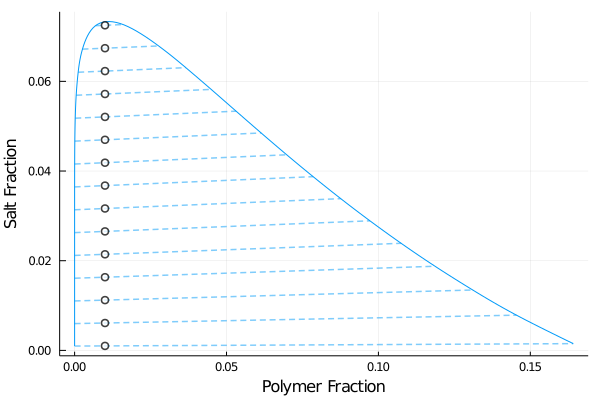

In [174]:
sort!(bndl, 2)

fig = plot(xlabel = "Polymer Fraction", ylabel = "Salt Fraction")
plot!(fig, bndl, map = x -> [x[1], x[2]], tie = true, interp = true, bulk = true)

## Asymmetric Coacervate

In [175]:
?AsymmetricCoacervate

search: AsymmetricCoacervate



```
AsymmetricCoacervate{TC <: AbstractChainStructure} <: AbstractModel{TC}
```

A coacervate model with asymmetric treatment of oppositely charged polyions and small salt ions.


In [180]:
omega = [1.0, 1.0, 1.0, 1.0]
sig = 0.25
dp = 100
b = 1.0

model = AsymmetricCoacervate(structure = GaussianCoil,
    omega = omega, sig = [sig, sig], dp = [dp, dp], b = [b, b]
)

AsymmetricCoacervate{GaussianCoil}(bulk = [0.0, 0.0, 0.0, 0.0])

Solve for asymmetric phase diagram.

Fix 4:1 ratio of of A/C chains in initial solution:
phiA0 = 0.01, phiC0 = 0.0025

State variables for bndlsolve:
x = [phiA1, phiC1, phiP1, phiM1, phiA2, phiC2, phiP2, phiM2, nu, psiG]

In [181]:
phiA0, phiC0 = (0.01, 0.0025)

salt = collect(range(0.032, 0.0; length = 20));
bulk = neutralbulk([phiA0, phiC0, salt[1]], model)
set_bulk!(model, bulk)

init = [0.007739898532241403, 0.0014283038758569437, 0.034294459783510436, 0.032716561119459, 0.012647372781773575, 0.003755332642344108, 0.03474075979891933, 0.032517749764074025, 0.4605427051402264, -0.009512565958433767]
state = bndlstate(init, model)

bndl = BinodalData()
for phiS in salt
    bulk = neutralbulk([phiA0, phiC0, phiS], model)
    set_bulk!(model, bulk)
    
    res = bndlsolve(init, model; scale = true, iterations = 100)
    if res.converged
        init = res.x
        add_state!(bndl, res.state) 
    else
        break
    end
end

Plot the binodal diagram in 3-dimensions.

Note the looping-in shape and the geometry of the asymmetric diagram.

Coexistence is along a 3D surface in the A-C-Salt plane.

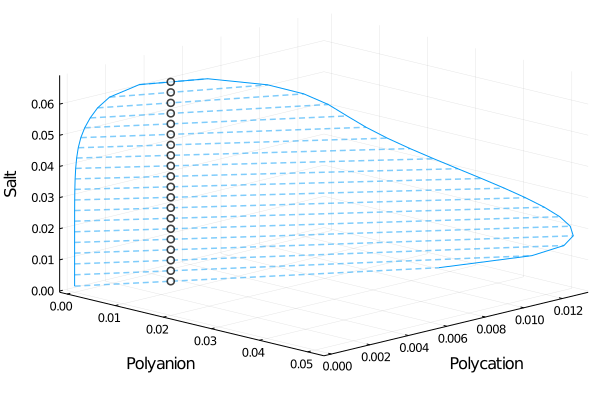

In [184]:
sort!(bndl, 3)

fig = plot(xlabel = "Polyanion", ylabel = "Polycation", zlabel = "Salt", camera = (45, 45))
plot!(fig, bndl, map = x -> [x[1], x[2], x[3]+x[4]], tie = true, bulk = true)

## Association Coacervate

In [185]:
?AssociationCoacervate

search: AssociationCoacervate



```
AssociationCoacervate{TC <: AbstractChainStucture} <: AbstractModel{TC}
```

A coacervate model with treament of reversible binding  for strongly dissociating polyelectrolytes.

At a given composition, the extent of each reaction is determined with the `association_solve` method. These reversible reactions represent:

1. Cation binding on the polyanions
2. Anion binding on the polycations
3. Formation of inter-chain ion-pairs between the polyions

References:

  * Salehi, A.; Larson, R. G. Macromolecules 2016, 49 (24), 9706–9719.
  * Friedowitz, S.; Salehi, A.; Larson, R. G.; Qin, J. J. Chem. Phys. 2018, 149 (16), 163335.


In [186]:
wP = 10
wS = 3
np = 50
chi = 0.5
dg = [-4, -4, -7]
b = 1.0 * wP^(1/3)

model = AssociationCoacervate(structure = GaussianCoil,
    omega = [wP, wP, wS, wS], dg = dg, chi = [chi, chi, 0.0],
    np = [np, np], b = [b, b]
)

;

In [187]:
phi = [0.001, 0.001, 0.005, 0.005]

ftotal(phi, model)

-0.026424302301291853

In [188]:
@time mutotal(phi, model)

  0.000681 seconds (159 allocations: 31.281 KiB)


4-element Array{Float64,1}:
 -0.6018164136695286
 -0.6018164136671792
 -2.2207762154534874
 -2.2207762154539616

Solve binodal diagram for `AssociationCoacervate`

Variables for `bndlsolve` same as for `AsymmetricCoacervate`.
x = [phiA1, phiC1, phiP1, phiM1, phiA2, phiC2, phiP2, phiM2, nu, psiG]

Often, it is helpful to get an initial seed point using `bndlminimize`, and then use that point to solve the remainder of the diagram using `bndlsolve`

In [193]:
phiA0, phiC0 = (0.005, 0.005)

salt = collect(range(0.0705, 0.005; length = 20))
bulk = neutralbulk([phiA0, phiC0, salt[1]], model)
set_bulk!(model, bulk)

init = [0.02676931850907985, 0.026854627189853687, 0.8062114720231559, 0.08813779501937438]
res = bndlminimize(init, model; iterations = 250, cycles = 5, show_trace = true)

Starting minimization -- f(x) = 2.6907e-07
Minimization cycle (1)  -- f(x) = -6.0203e-07
Minimization cycle (2)  -- f(x) = -6.0203e-07
Minimization cycle (3)  -- f(x) = -6.0203e-07
Minimization cycle (4)  -- f(x) = -6.0204e-07
Minimization cycle (5)  -- f(x) = -6.0204e-07


BinodalResults:
  x = [0.025159195371145738, 0.025447819341341205, 0.8080885765300669, 0.06427430069751719]
  steps = 194
  objective = -6.0204e-07
  converged = false


In [194]:
init = res.state
bndl = BinodalData()
for phiS in salt
    println("Working on phiS = $(phiS)")
    
    bulk = neutralbulk([phiA0, phiC0, phiS], model)
    set_bulk!(model, bulk)
    
    res = bndlsolve(init, model; scale = true, iterations = 50, ftol = 1e-8)
    
    if res.converged
        sup = res.x[1:4]
        coac = res.x[5:8]
        
        state = res.state
        state.props[:salt_bulk] = phiS
        state.props[:assoc_sup] = varsolve(sup, model, rlxn = 0.5)
        state.props[:assoc_coac] = varsolve(coac, model, rlxn = 0.5)
        add_state!(bndl, state)    
    
        init = state
    else
        break
    end
end

Working on phiS = 0.0705
Working on phiS = 0.06705263157894736
Working on phiS = 0.06360526315789473
Working on phiS = 0.060157894736842105
Working on phiS = 0.056710526315789475
Working on phiS = 0.05326315789473684
Working on phiS = 0.04981578947368421
Working on phiS = 0.04636842105263158
Working on phiS = 0.04292105263157895
Working on phiS = 0.039473684210526314
Working on phiS = 0.036026315789473684
Working on phiS = 0.032578947368421055
Working on phiS = 0.02913157894736842
Working on phiS = 0.02568421052631579
Working on phiS = 0.02223684210526316
Working on phiS = 0.018789473684210526
Working on phiS = 0.015342105263157895
Working on phiS = 0.011894736842105263
Working on phiS = 0.008447368421052632
Working on phiS = 0.005


Plot compositions and binding variables along phase diagram:

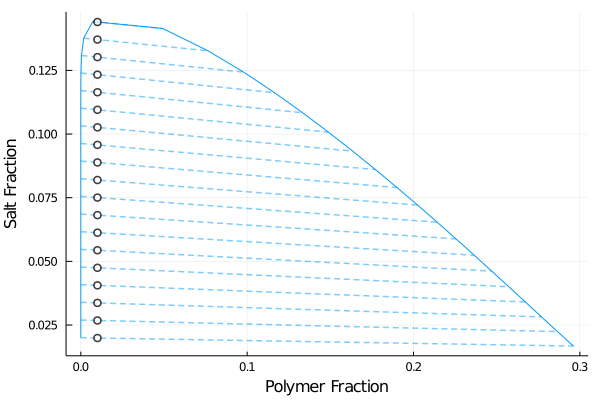

In [195]:
sort!(bndl, 3)

fig = plot(xlabel = "Polymer Fraction", ylabel = "Salt Fraction")
plot!(fig, bndl, map = x -> [x[1]+x[2], x[3]+x[4]], tie = true, bulk = true)

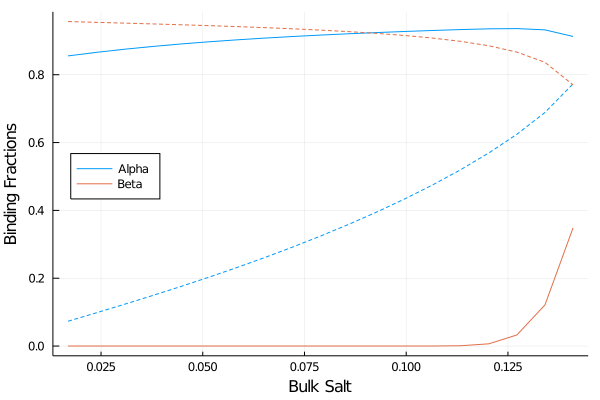

In [196]:
fig = plot(xlabel = "Bulk Salt", ylabel = "Binding Fractions")

salt_bulk = [2*state.props[:salt_bulk] for state in bndl]
alpha_sup = [state.props[:assoc_sup][1] for state in bndl]
alpha_coac = [state.props[:assoc_coac][1] for state in bndl]

beta_sup= [state.props[:assoc_sup][3] for state in bndl]
beta_coac = [state.props[:assoc_coac][3] for state in bndl]

plot!(fig, salt_bulk, alpha_sup, label = "Alpha")
plot!(fig, salt_bulk, alpha_coac, primary = false, ls = :dash)

plot!(fig, salt_bulk, beta_sup, label = "Beta")
plot!(fig, salt_bulk, beta_coac, primary = false, ls = :dash)

plot!(fig, legend = :left)
display(fig)